BUSI 525 - Empirical Asset Pricing - Spring 2024 
Assignment 1 - Skill versus Luck 

PART 1 - NO SKILLED FUNDS 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats 

In [17]:
np.random.seed(0)

N = 1000  
T = 120   
mean_market_return = 0.05 / 12  
sd_market_return = 0.2 / np.sqrt(12)  
sd_residual = 0.3 / np.sqrt(12)  

market_excess_returns = np.random.normal(mean_market_return, sd_market_return, T)

alphas = np.zeros(N)
t_stats = np.zeros(N) 

In [9]:
# Simulate each fund's returns and calculate alpha and t-statistic
for i in range(N):
    # Fund returns are market returns plus noise
    fund_returns = market_excess_returns + np.random.normal(0, sd_residual, T)
    
    # Estimate alpha and beta using linear regression
    beta, alpha = np.polyfit(market_excess_returns, fund_returns, 1)
    
    # Estimate the standard error of alpha
    residuals = fund_returns - (alpha + beta * market_excess_returns)
    standard_error = np.std(residuals) / np.sqrt(T)

    # Store alpha and its t-statistic
    alphas[i] = alpha
    t_stats[i] = alpha / standard_error 

In [10]:
significant_alphas = np.sum(np.abs(t_stats) > stats.t.ppf(1 - 0.05 / 2, T - 2)) 

print(f"Part 1.1 - Number of funds with significant alpha at the 5% level: {significant_alphas}")

Part 1.1 - Number of funds with significant alpha at the 5% level: 50


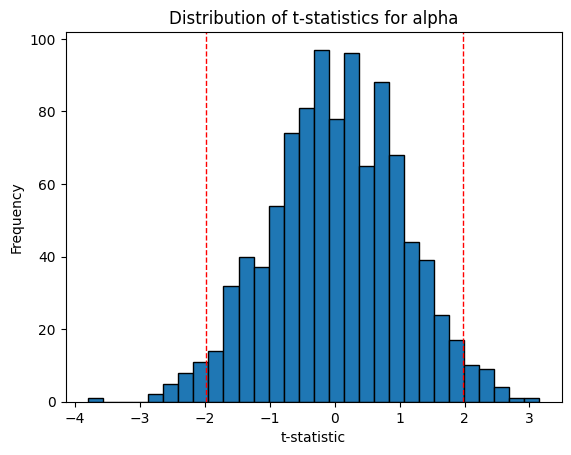

In [11]:
# Part 1.2 - Plot the histogram of t-statistics 

plt.hist(t_stats, bins=30, edgecolor='black')
plt.axvline(stats.t.ppf(1 - 0.05 / 2, T - 2), color='red', linestyle='dashed', linewidth=1)
plt.axvline(-stats.t.ppf(1 - 0.05 / 2, T - 2), color='red', linestyle='dashed', linewidth=1)
plt.title('Distribution of t-statistics for alpha')
plt.xlabel('t-statistic')
plt.ylabel('Frequency')
plt.show() 

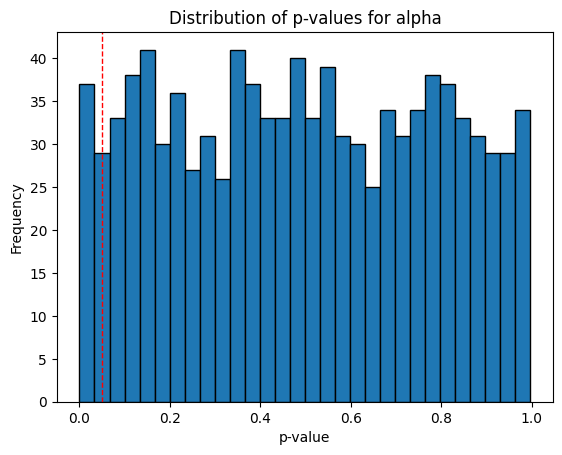

In [12]:
# Part 1.2 - Plot the histogram of p-values 

p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), T - 2))
plt.hist(p_values, bins=30, edgecolor='black')
plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1)
plt.title('Distribution of p-values for alpha')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show() 

Part 1.3 - The distribution of p-values (on average) follows a uniform distribution between 0 and 1, consistent with the fact that there the alpha is zero for all funds. Any significant alpha (those unusual p-values near 0) is likely due to random variation. 

PART 2 - SOME SKILLED FUNDS 

In [1]:
import statsmodels.api as sm 

/Users/khanhlynguyen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/khanhlynguyen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [19]:
annual_alpha_skilled = 0.025  
monthly_alpha_skilled = annual_alpha_skilled / 12 

lambda_values = [0.1, 0.25, 0.5, 0.75] 
simulation_results = {} 

In [26]:
def simulate_fund_statistics(lambd):

    alphas = np.zeros(N)
    t_stats = np.zeros(N)
    p_values = np.zeros(N)

    market_returns = np.random.normal(mean_market_return, sd_market_return, T)

    # Simulate returns for each fund
    for i in range(N):
        # Determine if fund is skilled or not
        if i < N * lambd:
            alpha = monthly_alpha_skilled
        else:
            alpha = 0
        
        fund_returns = alpha + market_returns + np.random.normal(0, sd_residual, T)

        X = sm.add_constant(market_returns)  # Add intercept
        model = sm.OLS(fund_returns, X).fit()
        estimated_alpha = model.params[0]

        # Store alpha, t-statistic and p-value
        alphas[i] = estimated_alpha
        t_stats[i] = model.tvalues[0]
        p_values[i] = model.pvalues[0]

    return alphas, t_stats, p_values 

In [27]:
for lambd in lambda_values:
    alphas, t_stats, p_values = simulate_fund_statistics(lambd)
    simulation_results[lambd] = {
        'alphas': alphas,
        't_stats': t_stats,
        'p_values': p_values
    } 

In [28]:
# Function to classify funds and calculate the confusion matrix elements
def classify_funds(alphas, t_stats, p_values, lambd, significance_level=0.05):
    num_skilled = int(N * lambd)
    num_unskilled = N - num_skilled

    true_alphas = np.array([monthly_alpha_skilled] * num_skilled + [0] * num_unskilled)

    classified_as_skilled = p_values < significance_level

    # Calculate true positives, false positives, false negatives, and true negatives
    TP = np.sum((classified_as_skilled[:num_skilled]))
    FN = num_skilled - TP
    FP = np.sum((classified_as_skilled[num_unskilled:]))
    TN = num_unskilled - FP

    return TP, FP, FN, TN

In [29]:
# Calculate classification rates for each lambda value
classification_results = {}

for lambd in lambda_values:
    TP, FP, FN, TN = classify_funds(simulation_results[lambd]['alphas'],
                                    simulation_results[lambd]['t_stats'],
                                    simulation_results[lambd]['p_values'],
                                    lambd)
    classification_results[lambd] = {
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'TPR': TP / (TP + FN),
        'FPR': FP / (FP + TN)
    }

In [24]:
import matplotlib.pyplot as plt 

Part 2.1 - Plot the distribution of α, t-stats, and p-values for each λ value. How does the p-value distribution change with the fraction of truly skilled funds? 

When λ = 0.1, the p-values are closed to uniformly distributed, which is consistent with the results in Part 1 where the funds have no skilled at all. 

As λ increases to 0.25 and 0.5, the distribution of p-values becomes more skewed to the right towards lower values, suggesting that with more skilled funds, there's a slightly higher probability of detecting skill. 

Lastly, with a high fraction of skilled funds (λ = 0.75), intuitively, we would expect the p-value distribution to show a pronounced skew towards lower values, reflecting a higher detection rate of true skill. However, in my simulation results, the distribution still remains somewhat uniform, which indicates that even with many skilled funds, the statistical tests are not very powerful in detecting true skill. This may be due to size of the alpha not being large enough to generate significant results. 

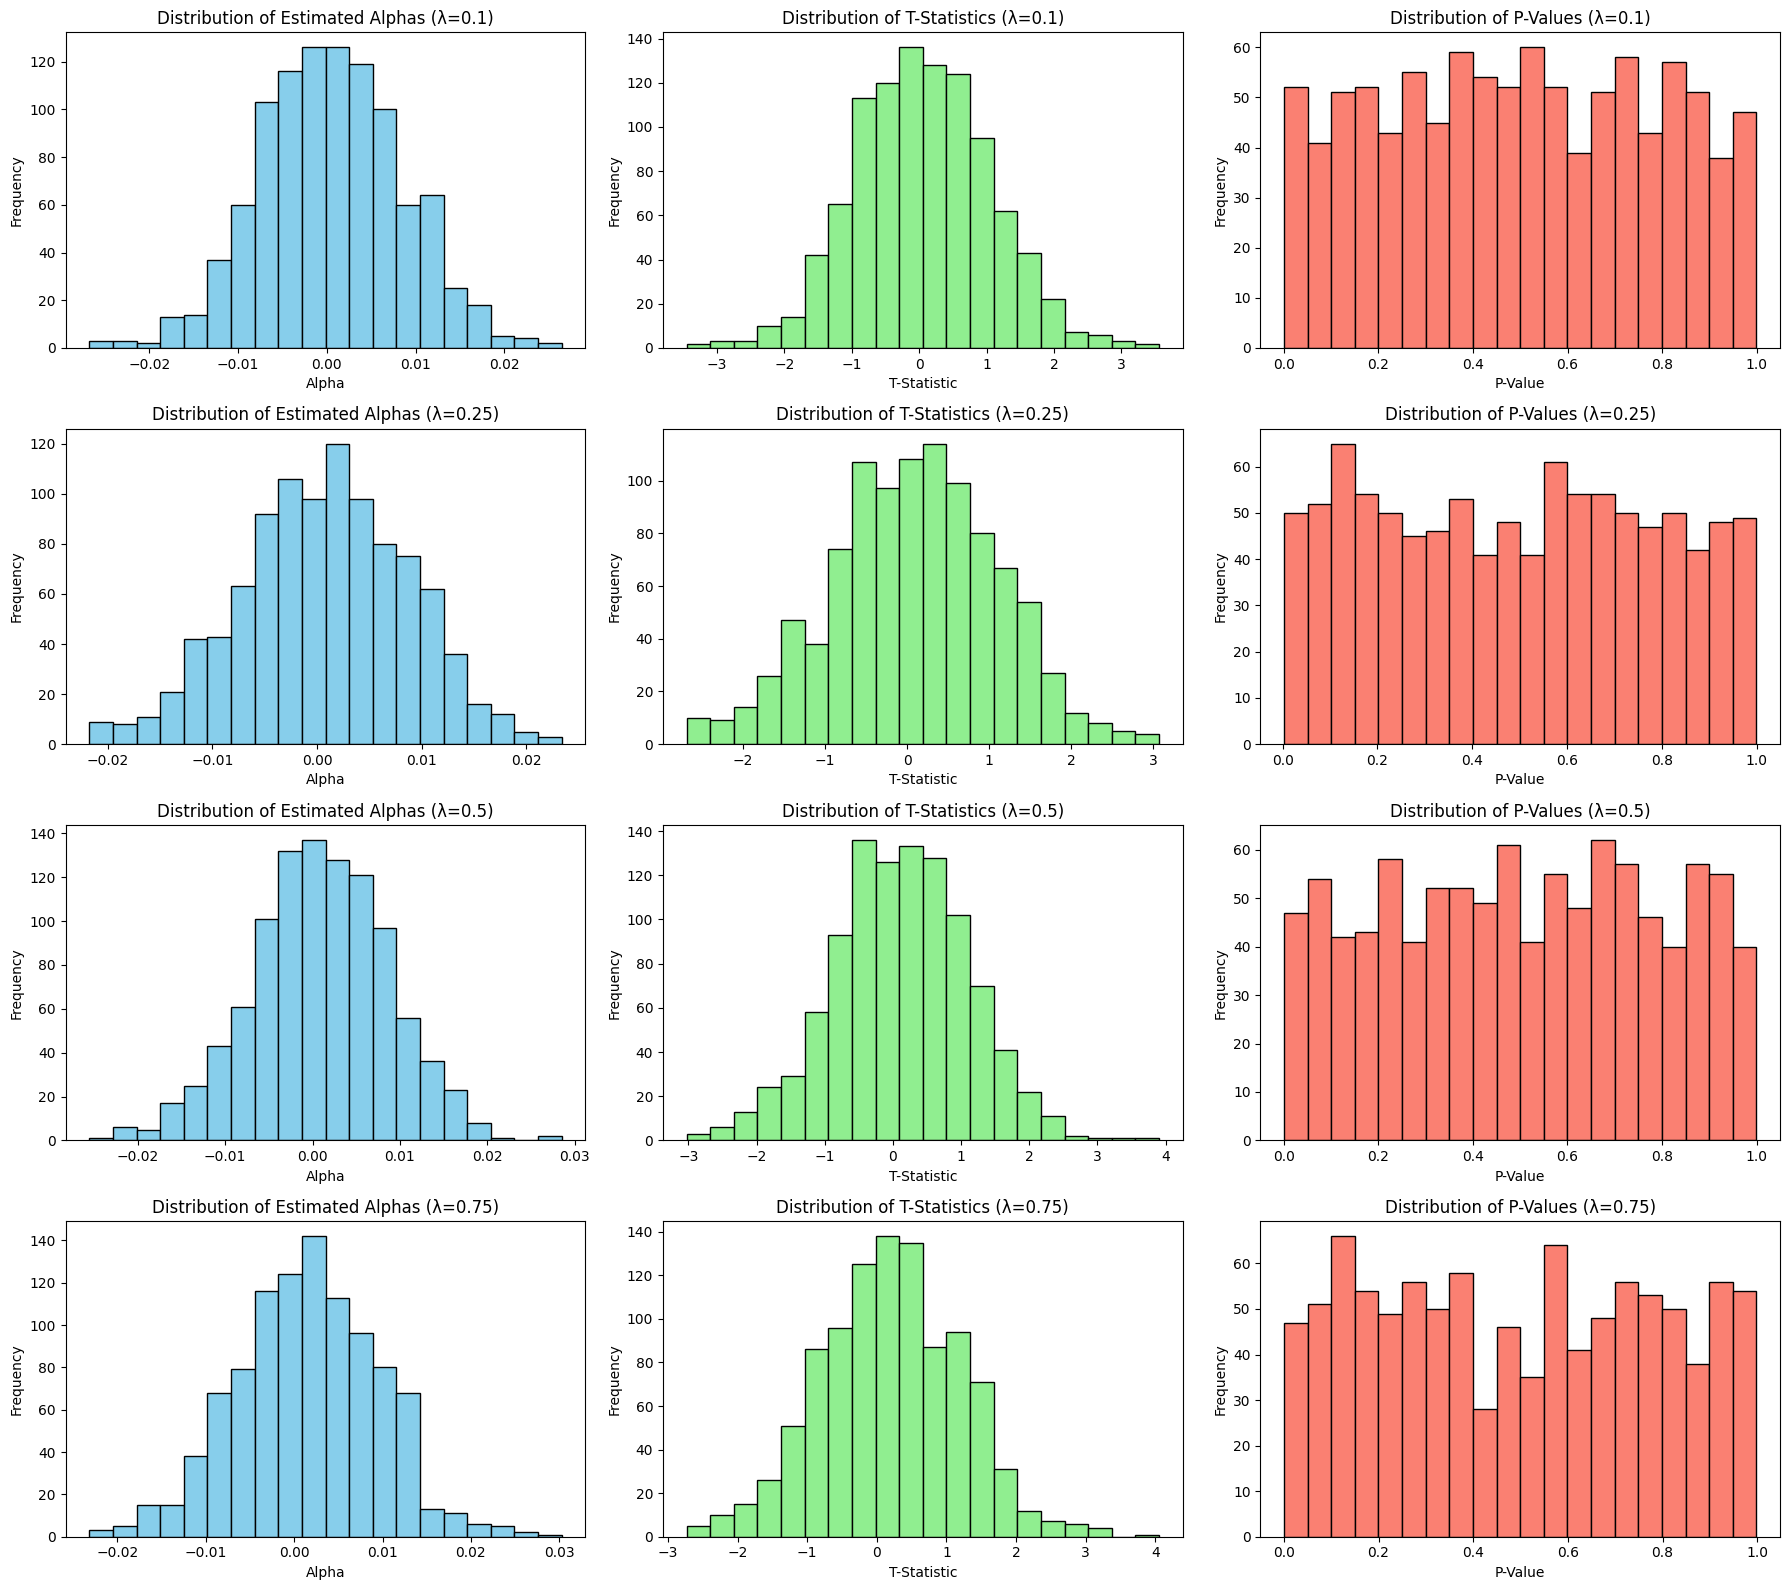

In [30]:
def plot_distributions(simulation_results, lambda_values):
    fig, axes = plt.subplots(len(lambda_values), 3, figsize=(18, 4 * len(lambda_values)))
    
    for i, lambd in enumerate(lambda_values):
        # Extracting results for the current lambda value
        results = simulation_results[lambd]
        alphas = results['alphas']
        t_stats = results['t_stats']
        p_values = results['p_values']

        # Plotting the distribution of estimated alphas
        axes[i, 0].hist(alphas, bins=20, color='skyblue', edgecolor='black')
        axes[i, 0].set_title(f'Distribution of Estimated Alphas (λ={lambd})')
        axes[i, 0].set_xlabel('Alpha')
        axes[i, 0].set_ylabel('Frequency')

        # Plotting the distribution of t-stats
        axes[i, 1].hist(t_stats, bins=20, color='lightgreen', edgecolor='black')
        axes[i, 1].set_title(f'Distribution of T-Statistics (λ={lambd})')
        axes[i, 1].set_xlabel('T-Statistic')
        axes[i, 1].set_ylabel('Frequency')

        # Plotting the distribution of p-values
        axes[i, 2].hist(p_values, bins=20, color='salmon', edgecolor='black')
        axes[i, 2].set_title(f'Distribution of P-Values (λ={lambd})')
        axes[i, 2].set_xlabel('P-Value')
        axes[i, 2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_distributions(simulation_results, lambda_values)

Part 2.2 - How many of the truly skilled funds have insignificant alpha estimates? And how many of the truly unskilled funds are identified as skilled based on significantly positive alpha estimates? For each λ value, report the percentage of funds: 

In [36]:
for lambd, results in classification_results.items():
    print(f"Lambda: {lambd}")
    for metric, value in results.items():
        print(f"{metric}: {value}")
    print("-" * 20) 

Lambda: 0.1
TP: 7
FP: 2
FN: 93
TN: 898
TPR: 0.07
FPR: 0.0022222222222222222
--------------------
Lambda: 0.25
TP: 11
FP: 14
FN: 239
TN: 736
TPR: 0.044
FPR: 0.018666666666666668
--------------------
Lambda: 0.5
TP: 28
FP: 19
FN: 472
TN: 481
TPR: 0.056
FPR: 0.038
--------------------
Lambda: 0.75
TP: 34
FP: 36
FN: 716
TN: 214
TPR: 0.04533333333333334
FPR: 0.144
--------------------
